# Data Preprocessing 

### sampling the data 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_palette('Accent')

In [3]:
data = pd.read_csv("MachineLearningCVE/MachineLearningCVE.csv")

In [4]:
data.shape

(2830743, 79)

In [7]:
# Dropping duplicates 
data.drop_duplicates(inplace = True)

# Replacing any infinite values (positive or negative) with NaN (not a number)
data.replace([np.inf, -np.inf], np.nan, inplace = True)

# Filling missing values with median
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
data['Flow Packets/s'].fillna(med_flow_packets, inplace = True)

# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack-Brute Force': 'Web Attack',
    'Web Attack-XSS': 'Web Attack',
    'Web Attack-Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Creating a new column 'Attack Type' in the DataFrame based on the attack_map dictionary
data['Attack Type'] = data['Label'].map(attack_map)

binary_attack = {
    'BENIGN': 0,  # Keep BENIGN as it is
}

# Add all other attack types from attack_map as 'Attack'
for attack_type in attack_map.values():
    if attack_type != 'BENIGN':
        binary_attack[attack_type] = 1

data['Target'] = data['Attack Type'].map(binary_attack)



le = LabelEncoder()
data['Attack Number'] = le.fit_transform(data['Attack Type'])

In [8]:
# For improving performance and reduce memory-related errors
old_memory_usage = data.memory_usage().sum() / 1024 ** 2
print(f'Initial memory usage: {old_memory_usage:.2f} MB')
for col in data.columns:
    col_type = data[col].dtype
    if col_type != object:
        c_min = data[col].min()
        c_max = data[col].max()
        # Downcasting float64 to float32
        if str(col_type).find('float') >= 0 and c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            data[col] = data[col].astype(np.float32)

        # Downcasting int64 to int32
        elif str(col_type).find('int') >= 0 and c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            data[col] = data[col].astype(np.int32)

new_memory_usage = data.memory_usage().sum() / 1024 ** 2
print(f"Final memory usage: {new_memory_usage:.2f} MB")

# Calculating percentage reduction in memory usage
print(f'Reduced memory usage: {1 - (new_memory_usage / old_memory_usage):.2%}')

Initial memory usage: 1587.64 MB
Final memory usage: 846.74 MB
Reduced memory usage: 46.67%


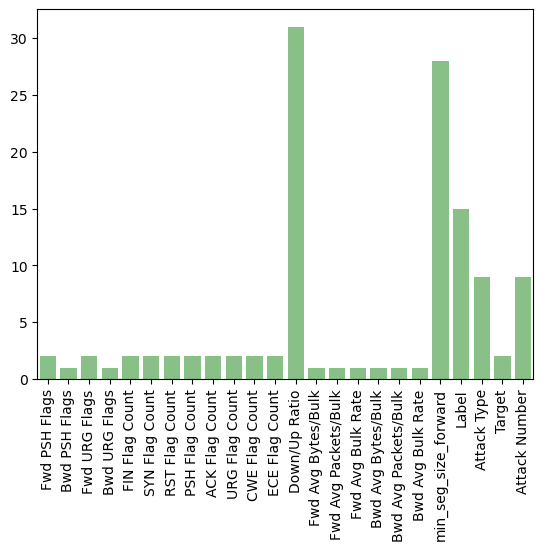

In [9]:
d = {f: data[f].nunique() for f in data.columns if data[f].nunique() < 50}
sns.barplot(d)
plt.xticks(rotation = 90)
plt.show()

'Dropped columns:'

Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

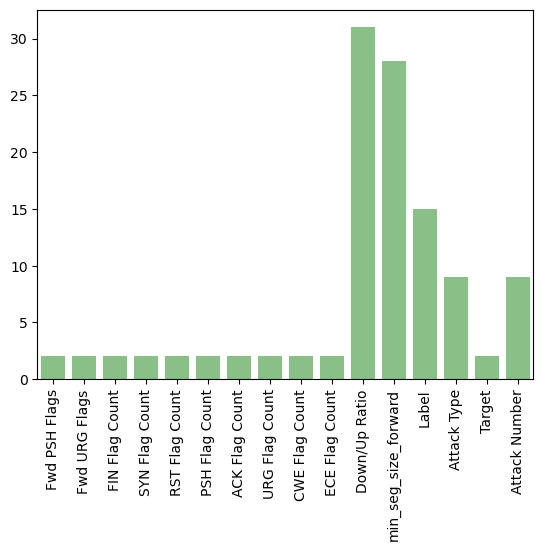

In [10]:
# dropping features with one unique value 
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

display('Dropped columns:')
display(dropped_cols)
d = {f: data[f].nunique() for f in data.columns if data[f].nunique() < 50}
sns.barplot(d)
plt.xticks(rotation = 90)
plt.show()

In [17]:
data.shape

(2522362, 74)

In [19]:
data = data.drop(["Label", "Attack Type", "Attack Number"], axis = 1)
data.shape

(2522362, 71)

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

cat_features = [feature for feature in data.columns if data[feature].nunique() < 50]


['Fwd PSH Flags',
 'Fwd URG Flags',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'CWE Flag Count',
 'ECE Flag Count',
 'Down/Up Ratio',
 'min_seg_size_forward',
 'Target']

In [27]:
for feature in cat_features :
    print(data[feature].value_counts())

Fwd PSH Flags
0    2399427
1     122935
Name: count, dtype: int64
Fwd URG Flags
0    2522282
1         80
Name: count, dtype: int64
FIN Flag Count
0    2441276
1      81086
Name: count, dtype: int64
SYN Flag Count
0    2399427
1     122935
Name: count, dtype: int64
RST Flag Count
0    2521676
1        686
Name: count, dtype: int64
PSH Flag Count
0    1771911
1     750451
Name: count, dtype: int64
ACK Flag Count
0    1734912
1     787450
Name: count, dtype: int64
URG Flag Count
0    2266525
1     255837
Name: count, dtype: int64
CWE Flag Count
0    2522282
1         80
Name: count, dtype: int64
ECE Flag Count
0    2521673
1        689
Name: count, dtype: int64
Down/Up Ratio
1      1541623
0       905392
2        48450
5        10661
3         6520
6         6452
4         2526
7          681
8           11
29           8
10           4
27           4
9            4
12           4
25           2
11           2
32           2
39           2
43           2
90           1
156          1
16 

In [175]:
unique_val_count_df = pd.DataFrame()

# Iterate through each categorical feature
for feature in cat_features:
    # Get rows where the value counts for the feature is equal to 1
    unique_rows = data[data[feature].isin(data[feature].value_counts()[data[feature].value_counts() <= 2].index)]
    
    # Append unique rows to the unique_val_count_df, avoiding duplicates
    unique_val_count_df = pd.concat([unique_val_count_df, unique_rows]).drop_duplicates()


In [177]:
unique_val_count_df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Target
430786,443,32251,1,108,6,243820,6,6,6.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
822362,443,4810,1,28,0,57598,0,0,0.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
844414,443,24266,1,25,0,49640,0,0,0.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
863312,443,4126,1,14,0,29200,0,0,0.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
903396,443,24850,1,35,0,64898,0,0,0.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
905466,4746,19997060,1,11,0,10,0,0,0.000000,0.000000,...,20,0.00,0.000000e+00,0,0,10000000.0,0.000000e+00,10000000,10000000,0
953606,443,6085,1,32,0,57598,0,0,0.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
1541296,445,6034391,1,39,6,234,6,6,6.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
1558260,445,6030204,1,43,6,258,6,6,6.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
1558593,443,6757,1,26,6,55486,6,6,6.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0


In [29]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming your data is loaded in a DataFrame called `data`
# Filter features with less than 50 unique values and more than 1 occurrence
features = list(data.columns)[:-1]
sampled_unique_counts = [data[feature].nunique() for feature in data.columns]
filtered_features = [
    feature for i, feature in enumerate(data.columns)
    if sampled_unique_counts[i] < 50 and sampled_unique_counts[i] > 1
]


# Remove rows with rare classes
for feature in filtered_features:
    counts = data[feature].value_counts()
    rare_classes = counts[counts < 2].index
    data_no_rare = data[~data[feature].isin(rare_classes)]

# Create a new label column by concatenating filtered features
data['stratify_label'] = data[filtered_features].astype(str).agg('-'.join, axis=1)

# Check the unique values in the stratify label to ensure no single counts
stratify_counts = data1['stratify_label'].value_counts()
rare_labels = stratify_counts[stratify_counts < 2].index
data1 = data1[~data1['stratify_label'].isin(rare_labels)]

# Initialize stratified split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Initialize list for batches
batches = []

# Stratified splitting
for train_idx, test_idx in sss.split(data1, data1['stratify_label']):
    batch = data1.iloc[test_idx].copy()
    batches.append(batch)



# Identify unique values in Down/Up Ratio
down_up_unique_values = data1['Down/Up Ratio'].unique()

# Perform stratified sampling first
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
batches = []

# Perform stratified sampling and create initial batches
for train_idx, test_idx in sss.split(data, data['stratify_label']):
    batch = data.iloc[test_idx].copy()
    batches.append(batch)

# Add missing values in Down/Up Ratio to each batch
for i, batch in enumerate(batches):
    # Identify missing values in the current batch
    missing_values = set(down_up_unique_values) - set(batch['Down/Up Ratio'].unique())
    
    # Get rows from the original data for these missing values
    missing_rows = data[data['Down/Up Ratio'].isin(missing_values)]
    
    # Append missing rows to the batch
    batch = pd.concat([batch, missing_rows]).drop_duplicates().reset_index(drop=True)
    
    # Update the batch in the list
    batches[i] = batch
    
    # Print verification
    print(f"Batch {i+1} distribution summary after adding missing values:")
    print(f"Down/Up Ratio unique values: Batch = {batch['Down/Up Ratio'].nunique()}, Full data = {len(down_up_unique_values)}")
    print("-" * 30)

# Check distribution of each batch
for i, batch in enumerate(batches):
    print(f"Batch {i+1} distribution summary:")
    batch_unique_counts = batch[filtered_features].nunique()
    full_data_unique_counts = data[filtered_features].nunique()
    
    for feature, batch_count, full_count in zip(filtered_features, batch_unique_counts, full_data_unique_counts):
        print(f"{feature}: Batch unique = {batch_count}, Full data unique = {full_count}")
    print("-" * 30)
# Drop the helper column if not needed
data.drop(columns=['stratify_label'], inplace=True)


Batch 1 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 2 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 3 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 4 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 5 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 1 distribution summary:
Fwd PSH Flags: Batch unique = 2, Full data unique = 2
Fwd URG Flags: Batch unique = 2, Full data unique = 2
FIN Flag Count: Batch unique = 2, Full data unique = 2
SYN Flag Count: Batch unique = 2, Full data unique = 2
RST Flag Count: Batch uniqu

In [179]:
# Read the CSV files into DataFrames
data1 = pd.read_csv("samples/federated_batch_1.csv")
data2 = pd.read_csv("samples/federated_batch_2.csv")
data3 = pd.read_csv("samples/federated_batch_3.csv")
data4 = pd.read_csv("samples/federated_batch_4.csv")
datatest = pd.read_csv("samples/test_batch.csv")

In [180]:
def add_rare_value(data, rare_df):
    data = data[unique_val_count_df.columns]
    data = pd.concat([data, unique_val_count_df])
    data = data.drop_duplicates().reset_index()
    data = data.drop(['index'], axis = 1)
    return data

In [183]:
data1 = add_rare_value(data1, unique_val_count_df)
data2 = add_rare_value(data2, unique_val_count_df)
data3 = add_rare_value(data3, unique_val_count_df)
data4 = add_rare_value(data4, unique_val_count_df)
datatest = add_rare_value(datatest, unique_val_count_df)


In [ ]:
data = data.drop(['stratify_label'], axis = 1)

In [186]:
def CountClasses(sample, full_data):
    # Get the feature names and unique value counts for both datasets
    features = list(full_data.columns)[:-1]
    sampled_unique_counts = [sample[feature].nunique() for feature in features]
    full_data_unique_counts = [full_data[feature].nunique() for feature in features]

    # Filter for features with less than 50 unique values
    filtered_features = [
        feature for i, feature in enumerate(features)
        if sampled_unique_counts[i] < 50 and full_data_unique_counts[i] < 50
    ]
    filtered_sampled_counts = [
        sampled_unique_counts[i] for i in range(len(features)) 
        if sampled_unique_counts[i] < 50 and full_data_unique_counts[i] < 50
    ]
    
    return filtered_sampled_counts, filtered_features

# Sampled and full dataset counts
filtered_sampled_counts1, filtered_features = CountClasses(data1, data)
filtered_sampled_counts2, _ = CountClasses(data2, data)
filtered_sampled_counts3, _ = CountClasses(data3, data)
filtered_sampled_counts4, _ = CountClasses(data4, data)
filtered_sampled_counts5, _ = CountClasses(datatest, data)
filtered_full_counts, _ = CountClasses(data, data)


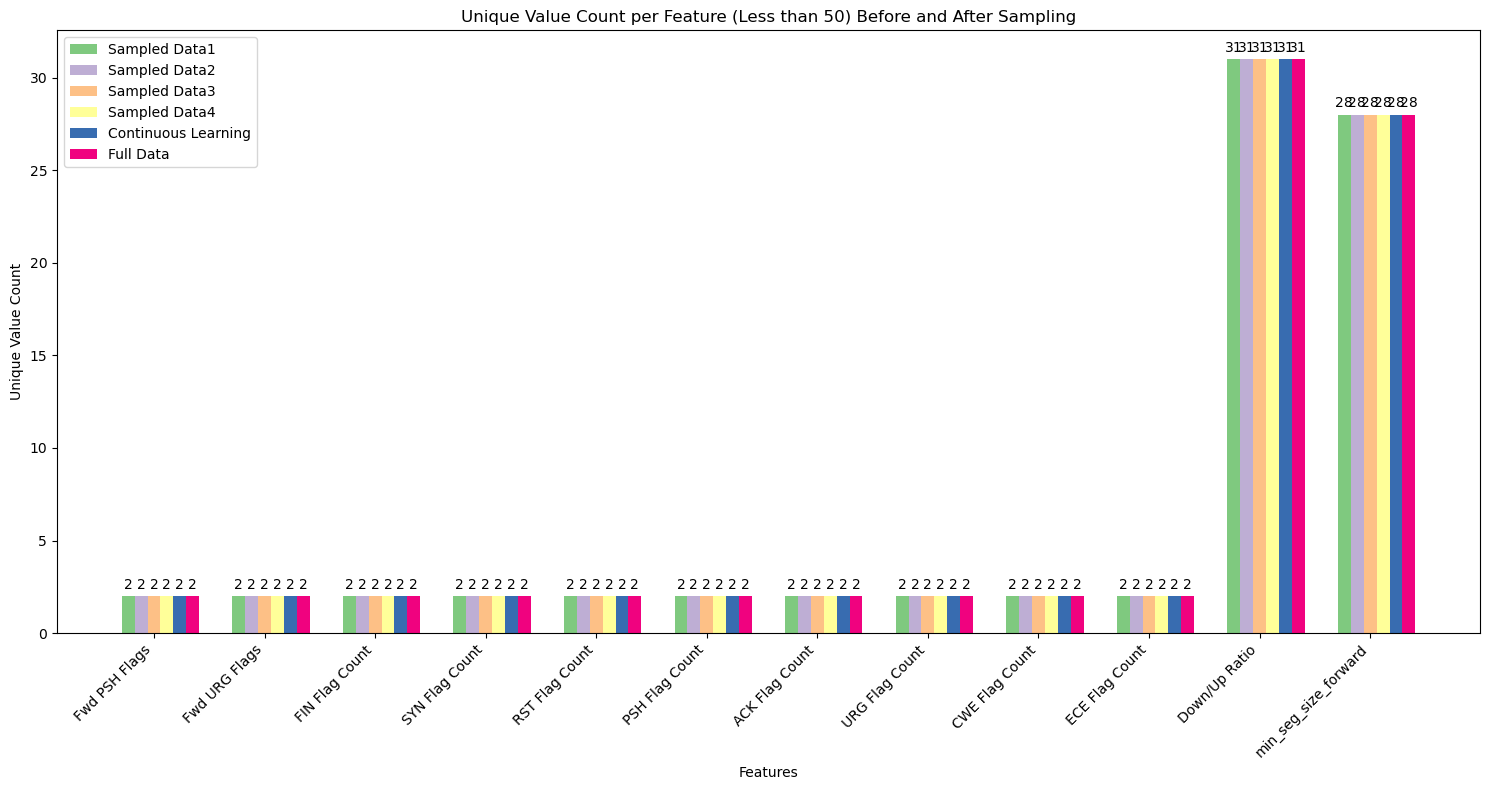

In [187]:
# Set the positions and width for the bars
x = np.arange(len(filtered_features))  # label locations
width = 0.7  # Increased width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot vertical bars for each dataset
rects1 = ax.bar(x - 2 * width / 6, filtered_sampled_counts1, width=width/6, label='Sampled Data1')
rects2 = ax.bar(x - width / 6, filtered_sampled_counts2, width=width/6, label='Sampled Data2')
rects3 = ax.bar(x, filtered_sampled_counts3, width=width/6, label='Sampled Data3')
rects4 = ax.bar(x + width / 6, filtered_sampled_counts4, width=width/6, label='Sampled Data4')
rects5 = ax.bar(x + 2 * width / 6, filtered_sampled_counts5, width=width/6, label='Continuous Learning')
rects6 = ax.bar(x + 3 * width / 6, filtered_full_counts, width=width/6, label='Full Data')


# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Features')
ax.set_ylabel('Unique Value Count')
ax.set_title('Unique Value Count per Feature (Less than 50) Before and After Sampling')
ax.set_xticks(x)
ax.set_xticklabels(filtered_features, rotation=45, ha="right")
ax.legend()


# Add a function to label the bars with their heights
def autolabel(rects):
    """Attach a text label above each bar, displaying its height (count)."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',  # Text label (height of the bar)
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # Position at the top of the bar
                    xytext=(0, 3),  # Offset slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')  # Center the label horizontally, place it above the bar

# Apply the autolabel function to all the bar sets
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

# Adjust layout to prevent overlap of x-axis labels
fig.tight_layout()

# Show the plot
plt.show()


* To improve performance and reduce the risk of memory-related errors (mostly session crashes), we downcasted the float and integer values based on the presence of the minimum and maximum values and reduced memory usage by 47.5%.

* The columns with zero standard deviation have the same value in all rows. These columns don't have any variance. It simply means that there is no meaningful relationship with any other columns. These columns cannot help differentiate between the classes or groups of data. So, we dropped the columns that have no variation.

* Created samples to perform feature engineering to reduce computational time

In [197]:
import os

# Create the folder if it doesn't exist
os.makedirs("processed_data", exist_ok=True)

# Save each sample with the specified names
data1.to_csv("processed_data/data1.csv", index=False)
data2.to_csv("processed_data/data2.csv", index=False)
data3.to_csv("processed_data/data3.csv", index=False)
data4.to_csv("processed_data/data4.csv", index=False)
datatest.to_csv("processed_data/datatest.csv", index=False)

print("All samples saved in the processed_data folder.")

All samples saved in the processed_data folder.


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("MachineLearningCVE/MachineLearningCVE.csv")
# Dropping duplicates
data.drop_duplicates(inplace=True)

# Replacing any infinite values (positive or negative) with NaN (not a number)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Filling missing values with median
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

data['Flow Bytes/s'].fillna(med_flow_bytes, inplace=True)
data['Flow Packets/s'].fillna(med_flow_packets, inplace=True)

# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack-Brute Force': 'Web Attack',
    'Web Attack-XSS': 'Web Attack',
    'Web Attack-Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}
# Creating a new column 'Attack Type' in the DataFrame based on the attack_map dictionary
data['Attack Type'] = data['Label'].map(attack_map)
binary_attack = {
    'BENIGN': 0,  # Keep BENIGN as it is
}

# Add all other attack types from attack_map as 'Attack'
for attack_type in attack_map.values():
    if attack_type != 'BENIGN':
        binary_attack[attack_type] = 1

data['Target'] = data['Attack Type'].map(binary_attack)

le = LabelEncoder()
data['Attack Number'] = le.fit_transform(data['Attack Type'])

# For improving performance and reduce memory-related errors
for col in data.columns:
    col_type = data[col].dtype
    if col_type != object:
        c_min = data[col].min()
        c_max = data[col].max()
        # Down-casting float64 to float32
        if str(col_type).find('float') >= 0 and c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            data[col] = data[col].astype(np.float32)

        # Down-casting int64 to int32
        elif str(col_type).find('int') >= 0 and c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            data[col] = data[col].astype(np.int32)

# dropping features with one unique value
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

data = data.drop(["Label", "Attack Type", "Attack Number"], axis=1)

cat_features = [feature for feature in data.columns if data[feature].nunique() < 50]

unique_val_count_df = pd.DataFrame()

# Iterate through each categorical feature
for feature in cat_features:
    # Get rows where the value counts for the feature is <= 2
    unique_rows = data[data[feature].isin(data[feature].value_counts()[data[feature].value_counts() <= 2].index)]

    # Append unique rows to the unique_val_count_df, avoiding duplicates
    unique_val_count_df = pd.concat([unique_val_count_df, unique_rows]).drop_duplicates()



In [20]:
# Filter features with less than 50 unique values and more than 1 occurrence
features = list(data.columns)[:-1]
sampled_unique_counts = [data[feature].nunique() for feature in data.columns]
filtered_features = [
    feature for i, feature in enumerate(data.columns)
    if sampled_unique_counts[i] < 50 and sampled_unique_counts[i] > 1
]

In [21]:
# Remove rows with rare classes
for feature in filtered_features:
    counts = data[feature].value_counts()
    rare_classes = counts[counts < 2].index
    data_no_rare = data[~data[feature].isin(rare_classes)]


In [22]:
# Create a new label column by concatenating filtered features
data['stratify_label'] = data[filtered_features].astype(str).agg('-'.join, axis=1)


In [23]:
# Check the unique values in the stratify label to ensure no single counts
stratify_counts = data['stratify_label'].value_counts()
rare_labels = stratify_counts[stratify_counts < 2].index
data1 = data[~data['stratify_label'].isin(rare_labels)]

In [33]:
# Initialize stratified split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Initialize list for batches
batches = []

# Stratified splitting
for train_idx, test_idx in sss.split(data1, data1['stratify_label']):
    batch = data1.iloc[test_idx].copy()
    batches.append(batch)
# Identify unique values in Down/Up Ratio
down_up_unique_values = data1['Down/Up Ratio'].unique()


# Add missing values in Down/Up Ratio to each batch
for i, batch in enumerate(batches):
    # Identify missing values in the current batch
    missing_values = set(down_up_unique_values) - set(batch['Down/Up Ratio'].unique())
    
    # Get rows from the original data for these missing values
    missing_rows = data[data['Down/Up Ratio'].isin(missing_values)]
    
    # Append missing rows to the batch
    batch = pd.concat([batch, missing_rows]).drop_duplicates().reset_index(drop=True)
    
    # Update the batch in the list
    batches[i] = batch

# Check distribution of each batch
for i, batch in enumerate(batches):
    batch_unique_counts = batch[filtered_features].nunique()
    full_data_unique_counts = data[filtered_features].nunique()
    
    for feature, batch_count, full_count in zip(filtered_features, batch_unique_counts, full_data_unique_counts):
        print(f"{feature}: Batch unique = {batch_count}, Full data unique = {full_count}")
    print("-" * 30)
# Drop the helper column if not needed
data.drop(columns=['stratify_label'], inplace=True)

Batch 1 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 2 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 3 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 4 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 5 distribution summary after adding missing values:
Down/Up Ratio unique values: Batch = 18, Full data = 18
------------------------------
Batch 1 distribution summary:
Fwd PSH Flags: Batch unique = 2, Full data unique = 2
Fwd URG Flags: Batch unique = 2, Full data unique = 2
FIN Flag Count: Batch unique = 2, Full data unique = 2
SYN Flag Count: Batch unique = 2, Full data unique = 2
RST Flag Count: Batch uniqu

In [35]:
def add_rare_value(data, rare_df):
    data = data[unique_val_count_df.columns]
    data = pd.concat([data, unique_val_count_df])
    data = data.drop_duplicates().reset_index()
    data = data.drop(['index'], axis = 1)
    return data
    

In [39]:
len(batches)

5

In [41]:

data1 = add_rare_value(batches[0], unique_val_count_df)
data2 = add_rare_value(batches[1], unique_val_count_df)
data3 = add_rare_value(batches[2], unique_val_count_df)
data4 = add_rare_value(batches[3], unique_val_count_df)
datatest = add_rare_value(batches[4], unique_val_count_df)

In [43]:
# Save each sample with the specified names
data1.to_csv("processed_data/data1.csv", index=False)
data2.to_csv("processed_data/data2.csv", index=False)
data3.to_csv("processed_data/data3.csv", index=False)
data4.to_csv("processed_data/data4.csv", index=False)
datatest.to_csv("processed_data/datatest.csv", index=False)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Target
0,53,59617,2,2,84,310,42,42,42.000000,0.000000,...,32,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
1,443,25472788,11,9,2108,688,752,0,191.636368,315.775970,...,20,1108446.50,1.534926e+06,2193803,23090,9902214.0,1.491748e+05,10000000,9796731,0
2,465,1916326,15,21,1303,1033,378,0,86.866669,93.894974,...,32,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
3,88,746,2,2,504,2884,252,252,252.000000,0.000000,...,32,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,0
4,80,1588978,4,0,24,0,6,6,6.000000,0.000000,...,20,0.00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503588,137,93624220,38,38,2116,2200,68,50,55.684212,8.479244,...,10,3935064.25,6.657832e+06,11600000,513,22600000.0,2.760000e+07,54500000,5036751,0
503589,443,110004856,13,20,260,400,20,20,20.000000,0.000000,...,38,138801.50,1.071267e+05,275204,52956,27300000.0,2.260000e+07,58300000,9777666,0
503590,443,119882397,5,7,100,140,20,20,20.000000,0.000000,...,46,1472008.50,1.693318e+06,2669365,274652,58500000.0,3.893641e+05,58700000,58200000,0
503591,443,108089748,4,9,80,180,20,20,20.000000,0.000000,...,46,114101.00,1.099509e+05,191848,36354,53900000.0,6.270852e+06,58300000,49500000,0
